In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import normaltest
from scipy.stats import levene
from sklearn.preprocessing import OrdinalEncoder

In [3]:
df = pd.read_csv("..\\data\\AB_Test_Results.csv")

In [4]:
df.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Feature Engineering

In [17]:
df["paying"] = df["REVENUE"] > 0

df_paying = df.loc[df["REVENUE"] > 0]

variant = df_paying.loc[df_paying["VARIANT_NAME"] == "control"]
control = df_paying.loc[df_paying["VARIANT_NAME"] == "variant"]

(0.0, 30.785)

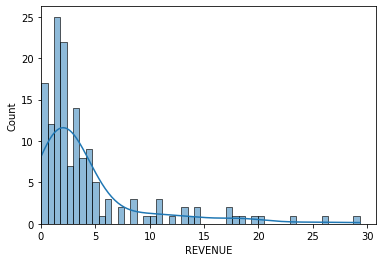

In [21]:
fig, ax = plt.subplots(1,1)

sns.histplot(
    data=df.loc[(df["REVENUE"] !=0) & (df["REVENUE"] < 30)],
    x="REVENUE",
    ax=ax,
    bins=50,
    kde=True
)

ax.set_xlim(0)

In [8]:
df.groupby("VARIANT_NAME").agg(
    mean_all=("REVENUE", "mean"),
    std_all=("REVENUE", "std"),
    n_in_group=("REVENUE", "count"),
    mean_paying=("REVENUE", lambda x: np.mean(x[x!=0])),
    std_paying=("REVENUE", lambda x: np.std(x[x!=0])),
    n_paying=("REVENUE", lambda x: sum(x != 0)),
    normal_test=("REVENUE", lambda x: normaltest(x)[1])
)

,mean_all,std_all,n_in_group,mean_paying,std_paying,n_paying,normal_test
VARIANT_NAME,,,,,,,
control,0.129013,3.007524,4984,8.037500,22.357069,80,0.0
variant,0.070070,1.314802,5016,4.881528,9.844885,72,0.0


A quick look a the summary statistics shows that the mean and the standard deviation of the 2 groups differ quite much. We should however conduct some statistical technique to check for the statistical significance of these differences. For now, I will only focuss on the differences in means of the paying customers. The column "normal_test" tests the null hypothesis that the samples come from a normal distribution. We can see that the null hypothesis gets rejected for both our groups.

This violates the first assumption of the t-test (that the data is normally distributed.). Also we should check, wether the groups have the same variance (so-called homogeneity of variance). For this, we might use Bartlett's test to test for equal variances but since our data is likely non-normally distributed we should use Levene's test which has more robustness in that case. Here, the null hypothesis is that the 2 groups have equal variances.

In [16]:
levene(control["REVENUE"], variant["REVENUE"])

LeveneResult(statistic=1.0050345981535496, pvalue=0.31770982736677544)

According to the test, we cannot reject the zero hypothesis. Please note that the absence of evidence against the hypothesis does not equal evidence **for** the hypothesis.

In [22]:
df_paying

,USER_ID,VARIANT_NAME,REVENUE,paying
13,2529,variant,2.15,True
49,6429,control,3.25,True
139,3331,variant,4.27,True
149,8110,variant,1.75,True
152,8607,control,2.99,True
...,...,...,...,...
9651,9928,variant,1.25,True
9711,6468,control,2.93,True
9724,5205,control,14.17,True
9725,702,variant,2.92,True


Bayesian Modelling

In [50]:
grp_idx, grp_names = pd.factorize(df_paying["VARIANT_NAME"])

In [46]:
import pymc as pm

with pm.Model() as model:

    mu=pm.Normal("mu", mu=3, sigma=2, dims="")
    sigma=pm.HalfNormal("sigma", sigma=10, shape=2)

    

    y = pm.Normal("obs",mu=mu[grp_idx], sigma=sigma[grp_idx], observed=df_paying["REVENUE"])

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 198 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

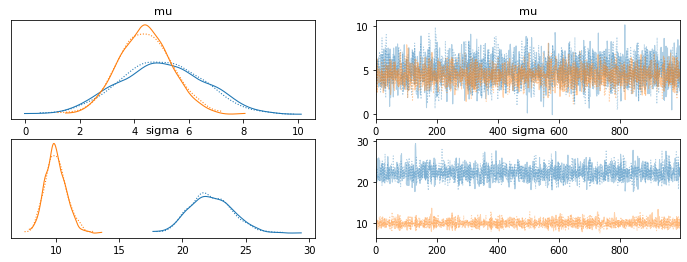

In [48]:
az.plot_trace(trace)